 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Feature-importance-from-from-linear-model" data-toc-modified-id="Feature-importance-from-from-linear-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature importance from from linear model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model-and-get-reference-score" data-toc-modified-id="Train-the-model-and-get-reference-score-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train the model and get reference score</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-random-permutation-scores-and-compute-feature-importance" data-toc-modified-id="Get-random-permutation-scores-and-compute-feature-importance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Get random permutation scores and compute feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#With-embeddings" data-toc-modified-id="With-embeddings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model" data-toc-modified-id="Train-the-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-feature-importance" data-toc-modified-id="Get-feature-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Neural-net-with-hidden-layer-and-embeddings" data-toc-modified-id="Neural-net-with-hidden-layer-and-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Neural net with hidden layer and embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model" data-toc-modified-id="Train-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Evaluate-feature-importance" data-toc-modified-id="Evaluate-feature-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evaluate feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Throw-away-&quot;useless&quot;-features" data-toc-modified-id="Throw-away-&quot;useless&quot;-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Throw away "useless" features</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-data" data-toc-modified-id="Get-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Build-a-neural-net-with-only-one-output" data-toc-modified-id="Build-a-neural-net-with-only-one-output-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build a neural net with only one output</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#BOOOOOST" data-toc-modified-id="BOOOOOST-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>BOOOOOST</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#CRPS-objective-function-for-XGBoost" data-toc-modified-id="CRPS-objective-function-for-XGBoost-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>CRPS objective function for XGBoost</a></span></li></ul></div>

# Feature importance

The skill of our models certainly increases with auxiliary variables. Of course we would like to know which of the 38 variables we added actually helped the predictions.

Random permutation importance gives us some insight. For this we randomly permute one feature at a time from the test set and evaluate the decrease in skill.

**TODO**
- Does pruning give more stable validation results? If yes, restructure paper? That would also necessitate rerunning all experiments. 
    - How do I find out. Run simple fc and "best" experiment several times and get variation.
    - But before I need to see if hyper-parameters have to be retuned.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from nn_src.imports import *

Using TensorFlow backend.


Anaconda environment: py36_keras
Darwin 17.4.0


In [3]:
DATA_DIR = '/Users/stephanrasp/data/'

In [6]:
# Open the dataset with training = 2015 and test = 2016
with open(DATA_DIR + 'pickled/aux_15_16.pkl', 'rb') as f:
    aux_train_set, aux_test_set = pickle.load(f)

## Feature importance from from linear model

### Train the model and get reference score

In [25]:
n_features = aux_train_set.features.shape[1]; n_features

40

In [13]:
aux_fc_model = build_fc_model(
    n_features=n_features,
    n_outputs=2,
    compile=True,
    lr=0.01
)

In [14]:
aux_fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [15]:
aux_fc_model.fit(
    aux_train_set.features, aux_train_set.targets, epochs=50, batch_size=1024, verbose=0);

In [16]:
aux_fc_model.evaluate(aux_train_set.features, aux_train_set.targets, 4096, 0)

0.95408068327495887

In [17]:
ref_score = aux_fc_model.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0); ref_score

0.91562945245394589

### Get random permutation scores and compute feature importance

In [33]:
def eval_shuf(m, idx, emb=False):
    x_shuf = aux_test_set.features.copy()
    x_shuf[:, idx] = np.random.permutation(x_shuf[:, idx])
    x = [x_shuf, aux_test_set.cont_ids] if emb else x_shuf
    return m.evaluate(x, aux_test_set.targets, 4096, 0)

In [34]:
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(aux_test_set.feature_names))]
    return np.array(scores) - ref_score

In [36]:
fimp = perm_imp(aux_fc_model)

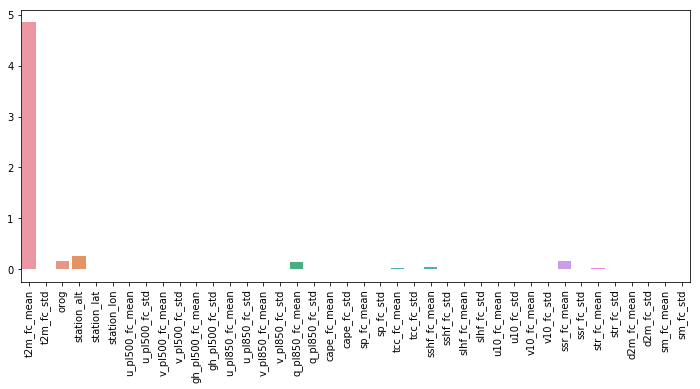

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp, x=aux_test_set.feature_names, ax=ax)
plt.xticks(rotation=90);

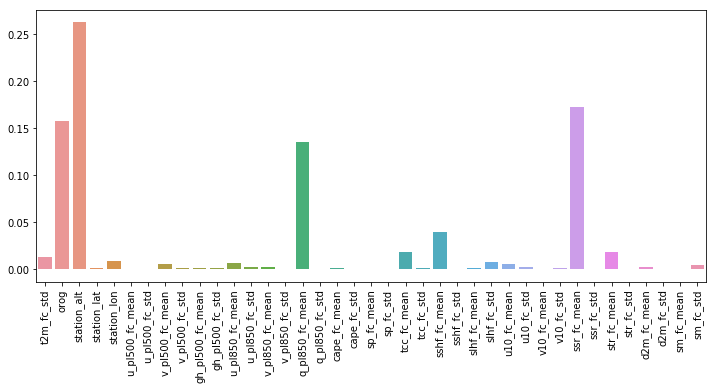

In [38]:
# Do not plot first bar
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp[1:], x=aux_test_set.feature_names[1:], ax=ax)
plt.xticks(rotation=90);

## With embeddings

### Train the model

In [27]:
emb_size = 2
max_id = int(np.max([aux_train_set.cont_ids.max(), aux_test_set.cont_ids.max()]))
max_id

536

In [28]:
aux_emb_model = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.01)
aux_emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 2)          1074        input_4[0][0]                    
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 2)             0           embedding_1[0][0]                
___________________________________________________________________________________________

In [29]:
aux_emb_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
                   epochs=50, batch_size=1024, verbose=0);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 3.2274     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 2.0904     
Epoch 3/50
180849/180849 [==============================] - 0s - loss: 1.7208     
Epoch 4/50
180849/180849 [==============================] - 0s - loss: 1.5229     
Epoch 5/50
180849/180849 [==============================] - 0s - loss: 1.3816     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 1.2773     
Epoch 7/50
180849/180849 [==============================] - 0s - loss: 1.1991     
Epoch 8/50
180849/180849 [==============================] - 0s - loss: 1.1383     
Epoch 9/50
180849/180849 [==============================] - 0s - loss: 1.0941     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 1.0594     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 1.0324     
Epoch 12/50
180849/180849 [==============================] - 0s - loss: 1.0127     
E

In [32]:
aux_emb_model.evaluate(
    [aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 4096, 0)

0.90725831819159775

In [30]:
emb_ref_score = aux_emb_model.evaluate(
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
emb_ref_score

0.88260775372673994

### Get feature importance

In [73]:
def perm_imp_emb(m, ref):
    scores = [eval_shuf(m, i, True) for i in range(len(aux_test_set.feature_names))]
    ids_shuf = np.random.permutation(aux_test_set.cont_ids)
    scores += [m.evaluate([aux_test_set.features, ids_shuf], aux_test_set.targets, 4096, 0)]
    return np.array(scores) - ref

In [74]:
fimp_emb = perm_imp_emb(aux_emb_model, emb_ref_score)

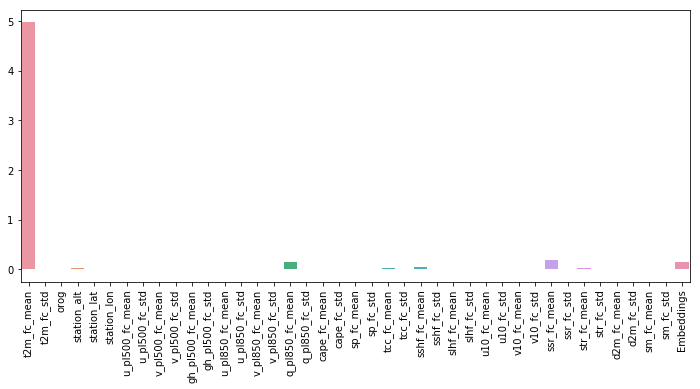

In [75]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb, x=aux_test_set.feature_names + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

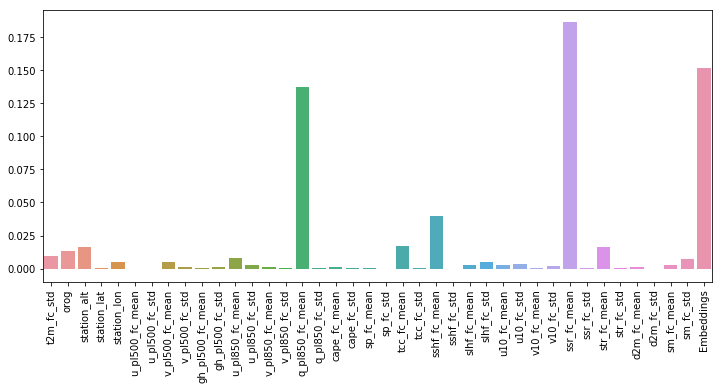

In [76]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb[1:], x=aux_test_set.feature_names[1:] + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

## Neural net with hidden layer and embeddings

This is our best configuration for one year of data.

### Train the model

In [44]:
emb_nnet = build_emb_model(n_features, 2, [50], emb_size, max_id, compile=True, lr=0.01)
emb_nnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 2)          1074        input_6[0][0]                    
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 2)             0           embedding_2[0][0]                
___________________________________________________________________________________________

In [45]:
emb_nnet.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
                   epochs=30, batch_size=1024, verbose=0);

In [46]:
emb_nnet.evaluate(
    [aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 4096, 0)

0.81640798948474369

In [47]:
emb_nnet_ref = emb_nnet.evaluate(
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
emb_nnet_ref

0.85484602477649974

### Evaluate feature importance

In [77]:
fimp_emb_nnet = perm_imp_emb(emb_nnet, emb_nnet_ref)

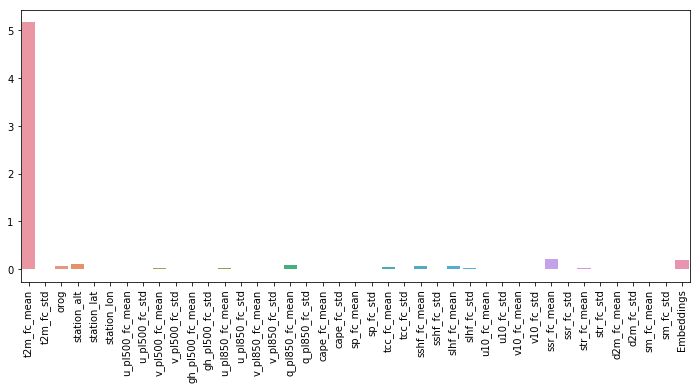

In [78]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb_nnet, x=aux_test_set.feature_names + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

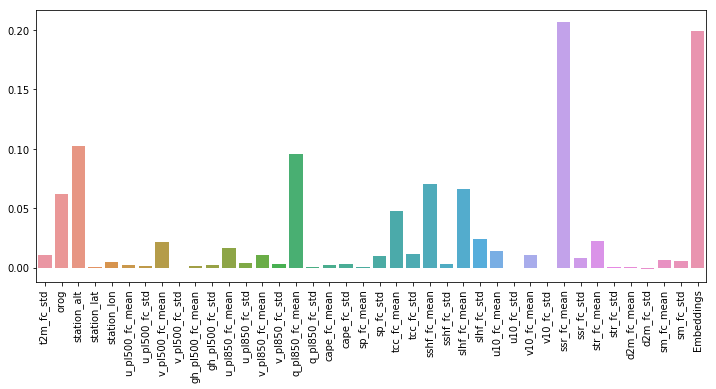

In [79]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(y=fimp_emb_nnet[1:], x=aux_test_set.feature_names[1:] + ['Embeddings'], ax=ax)
plt.xticks(rotation=90);

## Throw away "useless" features

In [80]:
fimp_emb_nnet[1]

0.010937333383072345

In [81]:
# Get only variables with importance > 0.005
pos_idxs = fimp_emb_nnet[:-1] > 0.005

In [82]:
pruned_train_features = aux_train_set.features[:, pos_idxs]
pruned_test_features = aux_test_set.features[:, pos_idxs]

In [83]:
n_pruned_features = pruned_test_features.shape[1]; n_pruned_features

21

In [84]:
pruned_nnet = build_emb_model(n_pruned_features, 2, [50], emb_size, max_id, compile=True, lr=0.01)
pruned_nnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 2)          1074        input_14[0][0]                   
____________________________________________________________________________________________________
input_13 (InputLayer)            (None, 21)            0                                            
____________________________________________________________________________________________________
flatten_6 (Flatten)              (None, 2)             0           embedding_6[0][0]                
___________________________________________________________________________________________

In [85]:
pruned_nnet.fit(
    [pruned_train_features, aux_train_set.cont_ids], aux_train_set.targets, 
    epochs=30, batch_size=1024,
    validation_data=([pruned_test_features, aux_test_set.cont_ids], aux_test_set.targets)
)

Train on 180849 samples, validate on 182218 samples
Epoch 1/30
180849/180849 [==============================] - 2s - loss: 2.1373 - val_loss: 1.0096
Epoch 2/30
180849/180849 [==============================] - 1s - loss: 0.9690 - val_loss: 0.9395
Epoch 3/30
180849/180849 [==============================] - 1s - loss: 0.9211 - val_loss: 0.8913
Epoch 4/30
180849/180849 [==============================] - 1s - loss: 0.9075 - val_loss: 0.9046
Epoch 5/30
180849/180849 [==============================] - 1s - loss: 0.8869 - val_loss: 0.8729
Epoch 6/30
180849/180849 [==============================] - 1s - loss: 0.8744 - val_loss: 0.8932
Epoch 7/30
180849/180849 [==============================] - 1s - loss: 0.8712 - val_loss: 0.9490
Epoch 8/30
180849/180849 [==============================] - 1s - loss: 0.8734 - val_loss: 0.8613
Epoch 9/30
180849/180849 [==============================] - 1s - loss: 0.8678 - val_loss: 0.8692
Epoch 10/30
180849/180849 [==============================] - 1s - loss: 0.8

In [86]:
pruned_nnet.optimizer.lr=0.001
pruned_nnet.fit(
    [pruned_train_features, aux_train_set.cont_ids], aux_train_set.targets, 
    epochs=10, batch_size=1024,
    validation_data=([pruned_test_features, aux_test_set.cont_ids], aux_test_set.targets)
)

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 1s - loss: 0.8326 - val_loss: 0.8427
Epoch 2/10
180849/180849 [==============================] - 1s - loss: 0.8284 - val_loss: 0.8463
Epoch 3/10
180849/180849 [==============================] - 1s - loss: 0.8357 - val_loss: 0.8386
Epoch 4/10
180849/180849 [==============================] - 1s - loss: 0.8286 - val_loss: 0.8475
Epoch 5/10
180849/180849 [==============================] - 1s - loss: 0.8272 - val_loss: 0.8477
Epoch 6/10
180849/180849 [==============================] - 1s - loss: 0.8290 - val_loss: 0.8472
Epoch 7/10
180849/180849 [==============================] - 1s - loss: 0.8295 - val_loss: 0.8605
Epoch 8/10
180849/180849 [==============================] - 1s - loss: 0.8270 - val_loss: 0.8532
Epoch 9/10
180849/180849 [==============================] - 1s - loss: 0.8217 - val_loss: 0.8429
Epoch 10/10
180849/180849 [==============================] - 1s - loss: 0.8

In [63]:
pruned_nnet.evaluate(
    [pruned_test_features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)

0.85985403252518833

In [88]:
from keras.regularizers import l2

In [98]:
from keras.layers import *

In [99]:
# Try l2 regularization
features_in = Input(shape=(n_pruned_features,))
id_in = Input(shape=(1,))
emb = Embedding(max_id + 1, emb_size)(id_in)
emb = Flatten()(emb)
x = Concatenate()([features_in, emb])
for h in [100, 100]:
    x = Dense(h, activation=LeakyReLU(0.2), kernel_regularizer=l2(1e-4))(x)
x = Dense(2, activation='linear')(x)
model = Model(inputs=[features_in, id_in], outputs=x)
model.compile(optimizer=Adam(0.01), loss=crps_cost_function)

/Users/stephanrasp/anaconda/envs/py36_keras/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [100]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_11 (Embedding)         (None, 1, 2)          1074        input_24[0][0]                   
____________________________________________________________________________________________________
input_23 (InputLayer)            (None, 21)            0                                            
____________________________________________________________________________________________________
flatten_11 (Flatten)             (None, 2)             0           embedding_11[0][0]               
___________________________________________________________________________________________

In [101]:
model.fit(
    [pruned_train_features, aux_train_set.cont_ids], aux_train_set.targets, 
    epochs=30, batch_size=1024,
    validation_data=([pruned_test_features, aux_test_set.cont_ids], aux_test_set.targets)
)

Train on 180849 samples, validate on 182218 samples
Epoch 1/30
180849/180849 [==============================] - 4s - loss: 1.6503 - val_loss: 1.0414
Epoch 2/30
180849/180849 [==============================] - 3s - loss: 0.9765 - val_loss: 0.9647
Epoch 3/30
180849/180849 [==============================] - 3s - loss: 0.9408 - val_loss: 0.8907
Epoch 4/30
180849/180849 [==============================] - 3s - loss: 0.9038 - val_loss: 0.8743
Epoch 5/30
180849/180849 [==============================] - 3s - loss: 0.8971 - val_loss: 0.8951
Epoch 6/30
180849/180849 [==============================] - 3s - loss: 0.8897 - val_loss: 0.9592
Epoch 7/30
180849/180849 [==============================] - 3s - loss: 0.8859 - val_loss: 0.8776
Epoch 8/30
180849/180849 [==============================] - 3s - loss: 0.8763 - val_loss: 0.8579
Epoch 9/30
180849/180849 [==============================] - 3s - loss: 0.8701 - val_loss: 0.9948
Epoch 10/30
180849/180849 [==============================] - 3s - loss: 0.8

# Old stuff

# XGBoost 

## Get data

As usual.

In [1]:
from importlib import reload
import utils; reload(utils)
from utils import *
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from crps_loss import crps_cost_function

Using Theano backend.


In [2]:
# Basic setup
DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
# DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU
results_dir = '../results/'

In [3]:
aux_dict = OrderedDict()
aux_dict['data_aux_geo_interpolated.nc'] = ['orog', 
                                            'station_alt', 
                                            'station_lat', 
                                            'station_lon']
aux_dict['data_aux_pl500_interpolated_00UTC.nc'] = ['u_pl500_fc',
                                                    'v_pl500_fc',
                                                    'gh_pl500_fc']
aux_dict['data_aux_pl850_interpolated_00UTC.nc'] = ['u_pl850_fc',
                                                    'v_pl850_fc',
                                                    'q_pl850_fc']
aux_dict['data_aux_surface_interpolated_00UTC.nc'] = ['cape_fc',
                                                      'sp_fc',
                                                      'tcc_fc']

In [4]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                          aux_dict=aux_dict)

train set contains 365 days
test set contains 366 days


## Build a neural net with only one output

In [5]:
def build_hidden_model(hidden_nodes, feature_size=2, out_size=1):
    inp = Input(shape=(feature_size,))
    x = Dense(hidden_nodes, activation='relu')(inp)
    x = Dense(out_size, activation='linear')(x)
    return Model(inputs=inp, outputs=x)

In [6]:
hidden_model = build_hidden_model(50, train_set.features.shape[1], 1)

In [7]:
hidden_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1250      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
hidden_model.compile(optimizer=Adam(0.001), loss='mse')

In [12]:
hidden_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 0s - loss: 3.1179 - val_loss: 3.0431
Epoch 2/10
180849/180849 [==============================] - 0s - loss: 3.1144 - val_loss: 3.0329
Epoch 3/10
180849/180849 [==============================] - 0s - loss: 3.1122 - val_loss: 3.0200
Epoch 4/10
180849/180849 [==============================] - 0s - loss: 3.1124 - val_loss: 3.0128
Epoch 5/10
180849/180849 [==============================] - 0s - loss: 3.1065 - val_loss: 3.0284
Epoch 6/10
180849/180849 [==============================] - 0s - loss: 3.1107 - val_loss: 3.0086
Epoch 7/10
180849/180849 [==============================] - 0s - loss: 3.1036 - val_loss: 3.0295
Epoch 8/10
180849/180849 [==============================] - 0s - loss: 3.1004 - val_loss: 3.0848
Epoch 9/10
180849/180849 [==============================] - 0s - loss: 3.0990 - val_loss: 3.0544
Epoch 10/10
180849/180849 [==============================] - 0s - loss: 3.0

In [13]:
np.sqrt(hidden_model.evaluate(test_set.features, test_set.targets))

174528/182218 [===========================>..] - ETA: 0s

1.7506607542837958

In [14]:
def build_linear_model(feature_size=2, out_size=1):
    inp = Input(shape=(feature_size,))
    x = Dense(out_size, activation='linear')(inp)
    return Model(inputs=inp, outputs=x)

In [15]:
linear_model = build_linear_model(train_set.features.shape[1], 1)

In [16]:
linear_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [17]:
linear_model.compile(optimizer=Adam(0.01), loss='mse')

In [23]:
linear_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 0s - loss: 3.2332 - val_loss: 3.0629
Epoch 2/10
180849/180849 [==============================] - 0s - loss: 3.2321 - val_loss: 3.0679
Epoch 3/10
180849/180849 [==============================] - 0s - loss: 3.2323 - val_loss: 3.0533
Epoch 4/10
180849/180849 [==============================] - 0s - loss: 3.2319 - val_loss: 3.0630
Epoch 5/10
180849/180849 [==============================] - 0s - loss: 3.2315 - val_loss: 3.0760
Epoch 6/10
180849/180849 [==============================] - 0s - loss: 3.2320 - val_loss: 3.0539
Epoch 7/10
180849/180849 [==============================] - 0s - loss: 3.2317 - val_loss: 3.0487
Epoch 8/10
180849/180849 [==============================] - 0s - loss: 3.2318 - val_loss: 3.0560
Epoch 9/10
180849/180849 [==============================] - 0s - loss: 3.2316 - val_loss: 3.0580
Epoch 10/10
180849/180849 [==============================] - 0s - loss: 3.2

In [24]:
w = linear_model.layers[1].get_weights()[0]

In [25]:
w.shape

(24, 1)

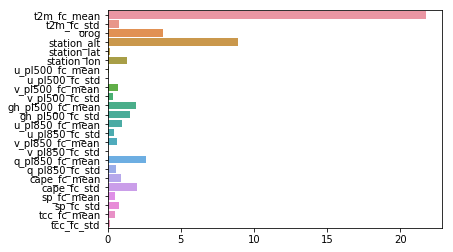

In [26]:
sns.barplot(y=train_set.feature_names, x=np.abs(w[:, 0]))

In [27]:
linear_model = build_linear_model(train_set.features.shape[1], 2)
linear_model.compile(optimizer=Adam(0.01), loss=crps_cost_function)

In [31]:
linear_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 0s - loss: 0.9751 - val_loss: 0.9555
Epoch 2/10
180849/180849 [==============================] - 0s - loss: 0.9738 - val_loss: 0.9508
Epoch 3/10
180849/180849 [==============================] - 0s - loss: 0.9728 - val_loss: 0.9496
Epoch 4/10
180849/180849 [==============================] - 0s - loss: 0.9723 - val_loss: 0.9471
Epoch 5/10
180849/180849 [==============================] - 0s - loss: 0.9716 - val_loss: 0.9515
Epoch 6/10
180849/180849 [==============================] - 0s - loss: 0.9713 - val_loss: 0.9435
Epoch 7/10
180849/180849 [==============================] - 0s - loss: 0.9711 - val_loss: 0.9444ss: 0
Epoch 8/10
180849/180849 [==============================] - 0s - loss: 0.9707 - val_loss: 0.9439
Epoch 9/10
180849/180849 [==============================] - 0s - loss: 0.9705 - val_loss: 0.9425
Epoch 10/10
180849/180849 [==============================] - 0s - loss

In [36]:
preds = linear_model.predict(test_set.features)
results_df = create_results_df(test_set.date_strs, test_set.station_ids,
                               preds[:, 0], preds[:, 1])
results_df.to_csv(results_dir + 'fc_network_aux_train_2015_pred_2016.csv')

In [32]:
w = linear_model.layers[1].get_weights()[0]
w.shape

(24, 2)

In [33]:
w

array([[ 21.55556107,  -0.70024198],
       [ -0.7106874 ,  -2.65330625],
       [  3.9828589 ,  -0.43749264],
       [-10.15917397,  -1.56758964],
       [ -0.55702108,   0.18167441],
       [ -1.12517023,  -0.26317564],
       [  0.18476054,  -0.13982216],
       [ -0.07289345,   0.68600416],
       [ -0.71506745,   0.07589541],
       [  0.46722719,   0.60490781],
       [  1.52971852,  -1.34756672],
       [ -1.14905655,   0.4754779 ],
       [  0.87684828,   0.14090069],
       [  0.43111378,  -0.75561202],
       [  0.49245536,  -0.56652683],
       [ -0.05685833,   0.14790827],
       [  3.03324747,   1.41057789],
       [  0.56196392,  -0.11340396],
       [ -0.41695151,   0.07533995],
       [  1.43556952,  -0.47592199],
       [ -0.12202962,  -0.23491184],
       [  0.24239618,   0.16700497],
       [  0.54675311,   0.60206783],
       [  0.27723232,  -0.11335158]], dtype=float32)

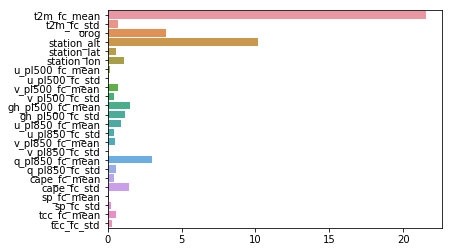

In [34]:
sns.barplot(y=train_set.feature_names, x=np.abs(w[:, 0]))

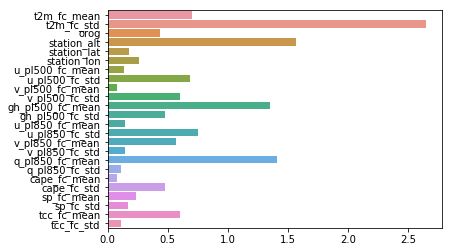

In [35]:
sns.barplot(y=train_set.feature_names, x=np.abs(w[:, 1]))

## BOOOOOST

In [18]:
import xgboost as xgb

/Users/stephanrasp/anaconda/envs/py36_keras/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [48]:
dtrain = xgb.DMatrix(train_set.features, train_set.targets, 
                     feature_names=train_set.feature_names)
dtest = xgb.DMatrix(test_set.features, test_set.targets, 
                     feature_names=test_set.feature_names)

In [51]:
our_params={
            'eta':0.3,
            'subsample':0.8,
            'objective':'reg:linear',
            'eval_metric': 'rmse',
            }
watchlist  = [(dtest,'eval'), (dtrain,'train')]

In [56]:
bst=xgb.train(our_params, dtrain, 30, watchlist)

[0]	eval-rmse:6.91028	train-rmse:6.92588
[1]	eval-rmse:5.02271	train-rmse:5.02794
[2]	eval-rmse:3.76052	train-rmse:3.75562
[3]	eval-rmse:2.94882	train-rmse:2.92686
[4]	eval-rmse:2.44828	train-rmse:2.40732
[5]	eval-rmse:2.14258	train-rmse:2.09606
[6]	eval-rmse:1.97091	train-rmse:1.91422
[7]	eval-rmse:1.87266	train-rmse:1.80578
[8]	eval-rmse:1.82303	train-rmse:1.74007
[9]	eval-rmse:1.79319	train-rmse:1.69971
[10]	eval-rmse:1.77206	train-rmse:1.66983
[11]	eval-rmse:1.76417	train-rmse:1.65135
[12]	eval-rmse:1.75511	train-rmse:1.63448
[13]	eval-rmse:1.75209	train-rmse:1.62086
[14]	eval-rmse:1.74149	train-rmse:1.60532
[15]	eval-rmse:1.7372	train-rmse:1.59292
[16]	eval-rmse:1.73616	train-rmse:1.58469
[17]	eval-rmse:1.7337	train-rmse:1.57744
[18]	eval-rmse:1.73108	train-rmse:1.5722
[19]	eval-rmse:1.73003	train-rmse:1.56726
[20]	eval-rmse:1.73132	train-rmse:1.55851
[21]	eval-rmse:1.72977	train-rmse:1.55354
[22]	eval-rmse:1.72867	train-rmse:1.54978
[23]	eval-rmse:1.72383	train-rmse:1.53983
[24]	

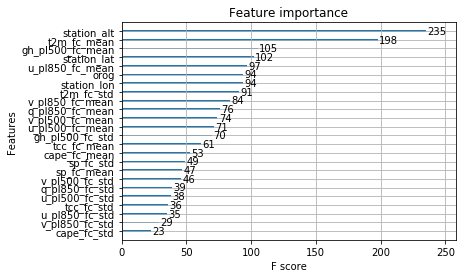

In [57]:
xgb.plot_importance(bst)

## CRPS objective function for XGBoost

In [58]:
# Doesn't work I think unless I do the binning stuff...